In [1]:
import pandas as pd

In [2]:

train_file_path = r"D:\iNeuronDataScience\Projects_iNeuron\MLPROJ\housing\artifact\data_ingestion\2022-09-30-16-32-52\ingested_data\train\housing.csv"


In [3]:
df = pd.read_csv(train_file_path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [4]:
df.shape

(16512, 10)

In [5]:
x,y = df.drop(columns = ["median_house_value"], axis=1), df[["median_house_value"]]

In [6]:
x.shape, y.shape

((16512, 9), (16512, 1))

In [7]:
x.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [8]:
# as of now nulls are present in 1 col : when i deployed project, we might get nulll values in other columns as well
# so how to handle those null values
# impute imputation on all features (numerical) as of now

In [9]:
numerical_column = x.drop(columns=['ocean_proximity'], axis=1)

In [10]:
from sklearn.impute import SimpleImputer
simple_imputer = SimpleImputer(strategy="median")
simple_imputer.fit_transform(numerical_column)

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [11]:
df_imputed = simple_imputer.transform(numerical_column)

In [12]:
simple_imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [13]:
simple_imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [14]:
# imputing categorical col
simple_imputer = SimpleImputer(strategy="most_frequent")


In [15]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


# tough we can use any transformer, still we are trying to learn making a custom transformer
COLUMN_TOTAL_ROOMS = "total_rooms"
COLUMN_POPULATION = "population"
COLUMN_HOUSEHOLDS = "households"
COLUMN_TOTAL_BEDROOM = "total_bedroom"

class FeatureGenerator(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room = True,
                total_rooms_ix = 3,
                population_ix = 5,
                households_ix = 6,
                total_bedrooms_ix = 4,
                columns = None):
        """
        FeatureGenerator Initialization

        add_bedroom_per_room: bool
        total_rooms_ix: int insdex number of total rooms column
        population_ix: int insdex number of total population column
        households_ix: int insdex number of households column
        total_bedroom_ix: int insdex number of bedrooms column
        """

        try:
            self.columns = columns
            if self.columns is not None:
                total_bedrooms_ix = self.columns.index(COLUMN_TOTAL_ROOMS)
                population_ix = self.columns.index(COLUMN_POPULATION)
                households_ix = self.columns.index(COLUMN_HOUSEHOLDS)
                total_bedrooms_ix = self.columns.index(COLUMN_TOTAL_BEDROOM)

            self.add_bedrooms_per_room = add_bedrooms_per_room
            self.total_rooms_ix = total_rooms_ix
            self.population_ix = population_ix
            self.households_ix = households_ix
            self.total_bedrooms_ix = total_bedrooms_ix


        except Exception as e:
            raise e


    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        try:
            room_per_household = x[:, self.total_rooms_ix] / x[:, self.households_ix]

            population_per_household = x[:, self.population_ix] / x[:, self.households_ix]

            if self.add_bedrooms_per_room : 
                bedrooms_per_room = x[:, self.total_bedrooms_ix] / x[:, self.total_rooms_ix]

                generated_feature = np.c_[x, room_per_household, population_per_household, bedrooms_per_room]

            else :
                generated_feature = np.c_[x, room_per_household, population_per_household]

            return generated_feature 

        except Exception as e:
            raise e



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # used to combine pipelines
# eg the steps we apply on numerical columns will differ from the steps being applied on categorical columns, so we need to combine at last

from sklearn.preprocessing import StandardScaler

# eg : 
numerical_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy="median")),
        ('feature_generator', FeatureGenerator()),
        ('scaling', StandardScaler())
    ]
)

from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('oneHotEncoder', OneHotEncoder()),
        ('scaling', StandardScaler(with_mean=False))
    ]
)

numerical_column_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

categorical_column_names = ['ocean_proximity']

#making combined pipeline
preprocessing = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_column_names),
    ('categorical_pipeline', categorical_pipeline, categorical_column_names)
])

In [17]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [22]:
# to run this we only need to use : 
# preprocessing.fit_transform(df)

# so in one,ine complete dataset has been transformed and ready for model training
# next time we can simply using again same preprocessing.fit_transform(new_df) to transform any new df received

training_df = preprocessing.fit_transform(df)

In [25]:
# # to save this file
# import dill

# with open('preprocessing.pkl', 'wb') as preprocessing_file:
#     dill.dump(preprocessing,preprocessing_file)

# # to use it afterwards (as its now saves as a pickle file)
# with open('preprocessing.pkl', 'rb') as file_obj:
#     preprocessing_loaded_obj = dill.load(file_obj)

# # now to use this 
# preprocessing_loaded_obj.transform(new_df)

In [27]:
# Trying some models

x = training_df
y = np.array(df['median_house_value'])

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(x,y)


LinearRegression()

In [28]:
lr.fit_intercept

True

In [29]:
lr.coef_

array([-5.56504627e+04, -5.67164575e+04,  1.37328360e+04, -1.93309162e+03,
        7.33003789e+03, -4.57082651e+04,  4.54554510e+04,  7.47143807e+04,
        6.60512598e+03,  1.04296102e+03,  9.24976398e+03,  2.90862108e+13,
        2.73006183e+13,  6.44744097e+11,  1.84660208e+13,  1.96144579e+13])

In [32]:
y_hat = lr.predict(x)
y_hat

array([210643.03125 , 317767.21875 , 210954.609375, ...,  95462.75    ,
       214351.5625  , 276424.734375])

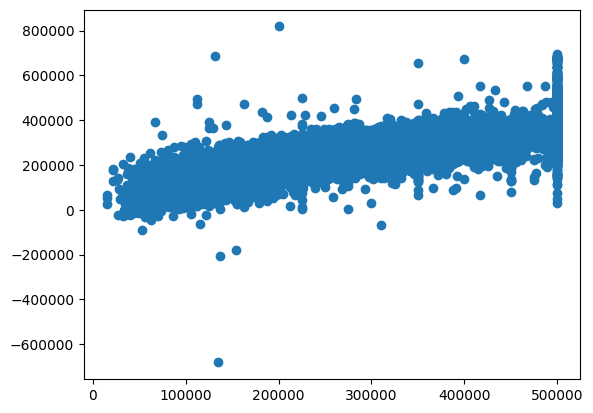

In [40]:
import matplotlib.pyplot as plt

plt.plot(y,y_hat, "o")


In [8]:
from collections import namedtuple

tryconfig = namedtuple("tryc", ["f1",
                                                                    "f2",
                                                                    "f3",
                                                                    "f4"])

print(tryconfig.f4)

_tuplegetter(3, 'Alias for field number 3')
